In [34]:
#Dataset from Kraken
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import TimestampType
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as mplt
import matplotlib.dates as mdates

spark = SparkSession.builder.getOrCreate()

In [35]:
path = "./data/bitcoin/btc-dataset-2021.csv"
df = spark.read.format('csv').options(header=True, inferSchema=True).load(path)
df.printSchema()

root
 |-- symbol: string (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- date: string (nullable = true)



In [36]:
df.take(5)

[Row(symbol='XXBTZUSD', timestamp=1381017600, open=122.0, high=122.0, low=122.0, close=122.0, volume=0.1, date='06/10/2013'),
 Row(symbol='XXBTZUSD', timestamp=1381104000, open=123.61, high=123.61, low=123.61, close=123.61, volume=0.1, date='07/10/2013'),
 Row(symbol='XXBTZUSD', timestamp=1381190400, open=123.91, high=124.19, low=123.9, close=124.18, volume=3.9916, date='08/10/2013'),
 Row(symbol='XXBTZUSD', timestamp=1381276800, open=124.0169, high=124.0169, low=123.84, close=123.84, volume=2.823, date='09/10/2013'),
 Row(symbol='XXBTZUSD', timestamp=1381363200, open=125.85, high=125.86, low=125.85, close=125.86, volume=2.2, date='10/10/2013')]

In [37]:
df.count()

2652

In [38]:
df.select("open", "high", "low", "close", "volume").describe().show()

+-------+-----------------+------------------+-----------------+------------------+------------------+
|summary|             open|              high|              low|             close|            volume|
+-------+-----------------+------------------+-----------------+------------------+------------------+
|  count|             2652|              2652|             2652|              2652|              2652|
|   mean|4591.880552413269|4734.4745029034675|4436.688028167417| 4605.072489328799|  3567.59356979638|
| stddev|5417.269114815493| 5617.747840251248|5187.291824274236|5449.7946556585775|4325.6526235130905|
|    min|            122.0|             122.0|            122.0|             122.0|               0.0|
|    max|          40644.2|           41989.0|          38765.2|           40666.7|        45110.8734|
+-------+-----------------+------------------+-----------------+------------------+------------------+



In [39]:
@udf(returnType = TimestampType())
def transform_timestamp_in_date(timestamp):
    return datetime.strptime(timestamp, "%d/%m/%Y")

In [40]:
df.filter(F.year(transform_timestamp_in_date("date")) == "2014").collect()

[Row(symbol='XXBTZUSD', timestamp=1388534400, open=737.1511, high=759.1104, low=737.1511, close=753.99, volume=10.1269, date='01/01/2014'),
 Row(symbol='XXBTZUSD', timestamp=1388620800, open=750.1158, high=817.5615, low=750.0, close=788.3042, volume=19.8134, date='02/01/2014'),
 Row(symbol='XXBTZUSD', timestamp=1388707200, open=784.686, high=819.9, low=771.178, close=808.5178, volume=75.6953, date='03/01/2014'),
 Row(symbol='XXBTZUSD', timestamp=1388793600, open=808.4269, high=840.0, low=783.02, close=827.6478, volume=33.2266, date='04/01/2014'),
 Row(symbol='XXBTZUSD', timestamp=1388880000, open=828.69, high=980.0, low=827.4135, close=904.75, volume=54.9491, date='05/01/2014'),
 Row(symbol='XXBTZUSD', timestamp=1388966400, open=908.25, high=1019.0, low=886.4398, close=919.1118, volume=75.0964, date='06/01/2014'),
 Row(symbol='XXBTZUSD', timestamp=1389052800, open=916.8197, high=945.0, low=810.0, close=810.0, volume=49.4082, date='07/01/2014'),
 Row(symbol='XXBTZUSD', timestamp=1389139

In [41]:
year = df.groupBy(F.year(transform_timestamp_in_date("date")).alias("year")) \
  .agg(F.max("high").alias("max"), F.avg("high").alias("avg"), F.min("high").alias("min"))
  
year.collect()

[Row(year=2018, max=17245.0, avg=7783.027676712326, min=3225.0),
 Row(year=2015, max=489.99, avg=278.8318139726028, min=202.1725),
 Row(year=2013, max=1198.8009, avg=564.178468235294, min=122.0),
 Row(year=2014, max=1019.0, avg=548.6399281690144, min=319.1378),
 Row(year=2019, max=13875.7, avg=7562.5167098630145, min=3382.4),
 Row(year=2020, max=29291.7, avg=11336.64672131147, min=5345.8),
 Row(year=2016, max=982.0, avg=576.0480153005466, min=373.5973),
 Row(year=2017, max=19660.0, avg=4118.183700273971, min=833.0),
 Row(year=2021, max=41989.0, avg=37351.17, min=29670.0)]

In [42]:
df_pandas = year.toPandas()
df_pandas

,year,max,avg,min
0,2018,17245.0000,7783.027677,3225.0000
1,2015,489.9900,278.831814,202.1725
2,2013,1198.8009,564.178468,122.0000
3,2014,1019.0000,548.639928,319.1378
4,2019,13875.7000,7562.516710,3382.4000
5,2020,29291.7000,11336.646721,5345.8000
6,2016,982.0000,576.048015,373.5973
7,2017,19660.0000,4118.183700,833.0000
8,2021,41989.0000,37351.170000,29670.0000


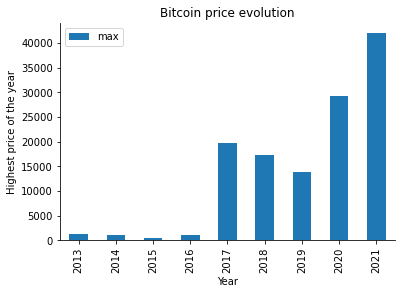

In [43]:
plt = df_pandas.sort_values(["year", "max"]) \
               .plot(kind="bar", x="year", y="max", title="Bitcoin price evolution")

plt.set_xlabel("Year")
plt.set_ylabel("Highest price of the year")

sns.despine()

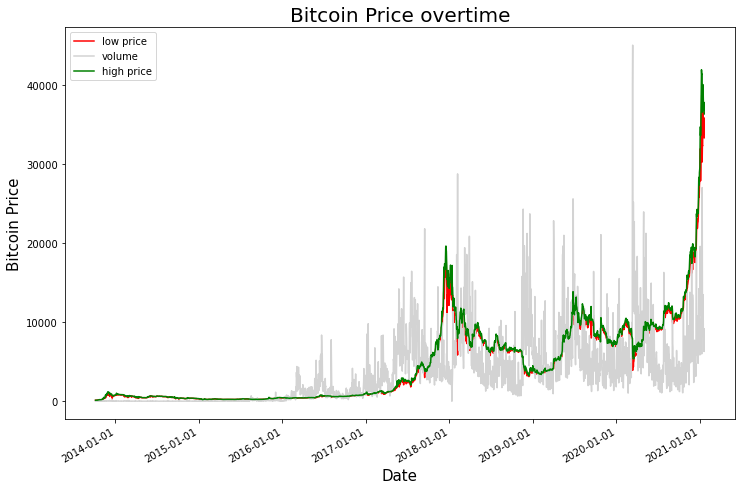

In [65]:
df_pandas = df.toPandas()
fig, ax = mplt.subplots(figsize=(12,8))
x3 = [datetime.strptime(d,'%d/%m/%Y').date() for d in df_pandas.date]

mplt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
mplt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
mplt.plot(x3, df_pandas.low, color='red', label='low price')
mplt.plot(x3, df_pandas.volume, color='lightgrey', label='volume')
mplt.plot(x3, df_pandas.high, color='green', label='high price')
mplt.gcf().autofmt_xdate()
mplt.xlabel("Date", fontsize=15)
mplt.ylabel("Bitcoin Price", fontsize=15)
mplt.title("Bitcoin Price overtime", fontsize=20)
mplt.legend(loc='best')
mplt.show()